# 1. Code for Classification with the QNN - part 1

In this version, the training data is always created in such a way that quantum states on the upper half of the Bloch sphere (z>0) receive the label 0, otherwise the assigned label is 1. Note that the QNN does not know why states carry their label. For other examples see version 2.

## 1.1 Package-imports, universal definitions and remarks

Import the relevant packages:

In [1]:
#math related packages
import numpy as np
import scipy as sc
import qutip as qt
#further packages
from time import time
from random import sample
from random import choice
import matplotlib.pyplot as plt
import csv

Declaration of qubit kets and density matrices:

In [2]:
#ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
#density matrices
qubit0mat = qubit0 * qubit0.dag()
qubit1mat = qubit1 * qubit1.dag()

Declaring functions for Dirac notation:

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

### Data conventions

The parameter QNN-Architecture $\text{qnnArch}$ describes the structure of a quantum neural network. It is expected to be a 1-dimensional list of natural numbers that which refer to the number of perceptrons in the corresponding layer. E.g. a 2-3-2 network would be given by $\text{qnnArch = [2, 3, 2]}$


Any parameter $\text{unitaries}$ is expected to be a 2-dimensional list of the networks perceptron unitaries (qutip.Qobj) given in a tensored state like

$$\text{unitaries}  = \big[ [\, ],[U_1^1, \dots, U_{m_1}^1], \dots, [U_1^l, \dots, U_{m_l}^l], \dots, [U_1^{out}, \dots, U_{m_{out}}^{out}]\big]$$

$$\text{unitaries[l][j]} = U_{j+1}^l$$

(The latter formula assumes that zero-indexing is not used for the perceptron unitaries, as is indicated in the former formula)


Any parameter $\text{trainingData}$ is expected to be a 2-dimensional list, where every inner list has exactly two elements like

$$trainingData = \big[ [\text{state}_1,\, \text{qubit0/1}], \dots , [\text{state}_N,\, \text{qubit0/1}] \big]$$

where $\text{unitary}$ is the targeted network unitary.

## 1.2 Helper functions for the QNN-Code

### Partial Trace

The $\text{partialTrace}$ functions assume to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of m factors $\{0, 1, \dots, m-1\}$. The functions then calculate and return the partial trace as follows:

$\text{partialTraceRem}$ traces out the factors $$\text{rem} \subsetneq \{0, \dots, m-1\}$$

$\text{partialTraceKeep}$ traces out the factors $$\big( \{0, \dots, m-1\} \setminus \text{keep}\big) \subsetneq \{0, \dots, m-1\}$$

No duplicates in $\text{rem}$ allowed. No values $\geq m$ in $\text{rem}$ or $\text{keep}$ allowed.

In [3]:
def partialTraceRem(obj, rem):
    #prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    #return partial trace:
    res = obj.ptrace(keep)
    return res

def partialTraceKeep(obj, keep):
    #return partial trace:
    return obj.ptrace(keep)

### Basis swap

$\text{swappedOp}$ assumes to be given a quantum object (qutip.Qobj) $\text{obj}$ that is the tensor product of $m$ factors. For

$$\text{obj} = A_0 \otimes \dots \otimes A_i \otimes \dots \otimes A_j \otimes \dots A_{m-1}$$

the function returns

$$A_0 \otimes \dots \otimes A_j \otimes \dots \otimes A_i \otimes \dots A_{m-1}$$

where $i, j \in \{1, \dots, m \}$.

In [4]:
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)

### Further functions

$\text{tensoredId}$ returns $\underbrace{\mathbb{1}_2 \otimes \dots \otimes \mathbb{1}_2}_{N \text{-times}}$

$\text{tensoredQubit0}$ returns $\ket{0 \dots 0}_N \bra{0 \dots 0}$

In [5]:
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #For some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

$\text{unitariesCopy}$ assumes to be given $\text{unitaries}$ as usual and returns a deep copy of it, meaning a new 2-dimensional list where every element is a copy of the element at the same position in the given 2d-list.

In [6]:
def unitariesCopy(unitaries):
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries

## 1.3 Random generation of unitaries, training data and networks

### Generation of random unitaries:

$\text{randomQubitUnitary}$ return a unitary $2^{\text{numQubits}} \times 2^{\text{numQubits}}$-matrix as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before orthogonalization, it's elements are randomly picked out of a normal distribution.

In [7]:
def randomQubitUnitary(numQubits):
    dim = 2**numQubits
    #Make unitary matrix
    res = sc.random.normal(size=(dim,dim)) + 1j * sc.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

### Bloch sphere

$\text{blochvec}$ maps an input state (as a density matrix) to a vector on the bloch sphere.

In [8]:
def blochvec(inputState):
     mat = 2 * sc.array(inputState)
     x = mat[0][1].real
     y = mat[1][0].imag
     z = mat[0][0].real - 1
     return [x,y,z]

### Generation of random training data

$\text{randomQubitState}$ return a unitary $2^{\text{numQubits}}$-vector as a quantum object (qutip.Qobj) that is the tensor product of $\text{numQubits}$ factors. Before normalization, it's elements are randomly picked out of a normal distribution.

$\text{randomTrainingData}$ returns a list of $N$ training pairs like

$$trainingData = \big[ [\text{state}_1,\, \text{qubit0/1}], \dots , [\text{state}_N,\, \text{qubit0/1}] \big]$$

To each input state, one of the basic states, qubit0 and qubit1, is assigned. They correspond to the labels 0 and 1. If $z>0$ for the vector on the Bloch sphere, the label is 0, otherwise 1.

In [9]:
def randomQubitState(numQubits):
    dim = 2**numQubits
    #Make normalized state
    res = sc.random.normal(size=(dim,1)) + 1j * sc.random.normal(size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res

def randomTrainingData(N):
    #numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        a = randomQubitState(1)
        b = a * a.dag()
        c = blochvec(b)
        d = qubit1
        if c[2]>0:
            d = qubit0
        trainingData.append([a,d])
    #Return
    return trainingData

### Note regarding Qobj.dims

Quantum objects $\text{Qobj}$ in the $\text{qutip}$ package have two properties regarding their sizes: $\text{shape}$ and $\text{dims}$. While $\text{shape}$ denotes the "dimensions of the underlying data matrix", $\text{dims}$ is a "list keeping track of shapes for individual components of a multipartite system" (quoted from the $\text{qutip}$-documentation). The qutip package will only allow operations such as the multiplication of two $\text{Qobj}$ objects $A$ and $B$, if not only their $\text{shape}$s, but also their $\text{dims}$ are compatible. Essentially all $\text{Qobj}$ objects in this work are representing operators or states in an multipartite system of $n$ qubits. As we create such objects with the desired $\text{shape}$, we have to ensure that their $\text{dims}$ are reflective of that, which is why we manually overwrite them to meet this criteria.

### Generation of an initial network

$\text{randomNetwork}$ will, given a valid $\text{qnnArch}$ as usual, return a 4-tuple that completely describes a trainable quantum-neural-network like

$$\big(\text{qnnArch}, \ \text{unitaries} , \ \text{trainingData}, \ \text{networkUnitary} \big)$$

With $\text{qnnArch},\, \text{unitaries}$ and $\text{trainingData}$ as usual and $\text{networkUnitary}$ being the targeted network unitary (with which the training data was created).

In [10]:
def randomNetwork(qnnArch, numTrainingPairs):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."
    
    #Create the targeted network unitary and corresponding training data
    networkTrainingData = randomTrainingData(numTrainingPairs)
    
    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]
        
        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
            unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
            networkUnitaries[l].append(unitary)
    
    #Return
    return (qnnArch, networkUnitaries, networkTrainingData)#, networkUnitary)

## 1.4 QNN-Code

### Cost Function

$\text{costFunction}$ assumes to be given $\text{trainingData}$ and $\text{outputStates}$ so that

$$\text{trainingData[x][1]} = \ket{\phi_x^{out}}$$

$$\text{outputStates[x]} = \rho_x^{out}(s)$$

and computes the cost function:

$$C(s) = \frac{1}{N} \sum_{x = 1}^N \bra{\phi_x^{out}} \rho_x^{out}(s) \ket{\phi_x^{out}}$$

In [11]:
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        costSum += trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]
    return costSum.tr()/len(trainingData)

### Layer-Channel & Adjoint-Layer-Channel

$\text{makeLayerChannel}$ assumes to be given $\text{qnnArch}$ and $\text{currentUnis}$ as usual and calculates

\begin{align}
\\
\mathcal{E}_s^l(X^{l-1}) & = \text{tr}_{l-1}\bigg( U^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^l(s)^{\dagger} \bigg) \\
& = \text{tr}_{l-1}\bigg( U_{m_l}^l(s) \dots U_1^l(s) \ \big( X^{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \bigg) 
\\
\end{align}

for $\text{inputState} = X^{l-1}$

In [12]:
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))

$\text{makeAdjointLayerChannel}$ assumes to be given $\text{qnnArch}$ and $\text{unitaries}$ as usual and calculates

\begin{align}
\\
\mathcal{F}_s^l(X^{l}) & = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U^{l}(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U^l(s) \bigg) \\
& = \text{tr}_{l}\bigg( \big( \mathbb{1}_{l-1} \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \ U_1^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \ \big( \mathbb{1}_{l-1} \otimes X^l \big) \ U_{m_l}^l(s) \dots U_1^l(s) \bigg)
\\
\end{align}


for $\text{inputState} = X^{l}$

In [13]:
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni
    
    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )

### Feedforward

$\text{feedforward}$ assumes to be given $\text{qnnArch},\, \text{unitaries}$ and $\text{trainingData}$ as usual, carries out the feedforward process as described in Appendix D.2 of ***Efficient Learning for Deep Quantum Neural Networks***:

For each element $\big[\, \ket{\phi_x^{in}},\, \ket{\phi_x^{out}} \big]$ in $\text{trainingData}$ do:

- Calculate the network input $\rho_x^{in} = \ket{\phi_x^{in}} \bra{\phi_x^{in}}$

- For every layer $l$ in $\text{qnnArch}$ do:

    - Apply the layer channel $\mathcal{E}_s^l$ to the output of the previous layer $l-1$

    - Store the result $\rho_x^l(s)$

In [14]:
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0] * trainingData[x][0].dag()
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates

### Update matrix

$\text{makeUpdateMatrix}$ assumes to be given $\text{qnnArch},\, \text{unitaries},\, \text{trainingData}$ and $\text{storedStates}$ as usual, as well as $\lambda,\, \epsilon \in \mathbb{R}$, and calculates

$$\text{exp}\big( i \, \epsilon \, K_j^l(s) \big)$$

with

$$K_j^l(s) = \frac{2^{n_{a_1, \dots, \beta}} \, i}{2 N \lambda} \sum_x \text{tr}_\text{rest} M_j^l(s)$$

with 

$$M_j^l(s) = \big[A_j^l(s), B_j^l(s) \big]$$

with

\begin{align}
A_j^l(s) & = U_j^l(s) \dots U_1^l(s) \, \big( \rho_x^{l-1}(s) \otimes \ket{0 \dots 0}_l \bra{0 \dots 0} \big) \, U_1^l(s)^{\dagger} \dots U_j^l(s)^{\dagger} \\
\\
B_j^l(s) & = U_{j+1}^l(s)^{\dagger} \dots U_{m_l}^l(s)^{\dagger} \, \big( \mathbb{1}_l \otimes \sigma_x^l(s) \big) \, U_{m_l}^l(s) \dots U_{j+1}^l(s)
\end{align}

with

$$\sigma_x^l(s) = \mathcal{F}_s^{l+1} \big( \dots \mathcal{F}_s^{out} \big( \ket{\phi_x^{out}} \bra{\phi_x^{out}} \big) \dots \big)$$

$\text{updateMatrixFirstPart}$ calculates $A_j^l(s)$, $\text{updateMatrixSecondPart}$ calculates $B_j^l(s)$.

$\text{makeUpdateMatrixTensored}$ tensors the calculated as above update matrix in such a way, that it can be applied to the already tensored perceptron unitaries.

In [15]:
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]
    
    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)
        
        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)
        
        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))
    
    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni
    
    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Calculate sigma state
    state = trainingData[x][1] * trainingData[x][1].dag()
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)
    
    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni
        
    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    res = qt.tensor(makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j), tensoredId(numOutputQubits-1))
    
    return swappedOp(res, numInputQubits, numInputQubits + j)

### Training of the Quantum Neural Network

$\text{qnnTraining}$ assumes to be given $\text{qnnArch},\, \text{initialUnitaries}$ and $\text{trainingData}$ as usual, as well as $\lambda,\, \epsilon \in \mathbb{R}$ and $\text{trainingRounds} \in \mathbb{N}$, and trains the given quantum neural network as summarized in Figure 2 of ***Efficient Learning for Deep Quantum Neural Networks***:

**Step 1: Feedforward:** For every training pair, for every layer: Apply the layer channel $\mathcal{E}^l$ and store the result

**Step 2: Updating:** Update every unitary in every layer according to $U^l_j \rightarrow e^{i \, \epsilon \, K^l_j} \ U^l_j$

**Termination: Repeat Steps 1 and 2 $\text{trainingRounds}$ times**

In [16]:
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):
    
    ### FEEDFORWARD    
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)]]
    
    #Optional
    runtime = time()
    
    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))
        
        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)
        
        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]
            
            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])
        
        ### FEEDFORWARD
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
        
        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
    
    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")
    
    #Return
    return [plotlist, currentUnitaries]

## 1.5 Classification after training

The following function simulates $R$ mesurements for each state. The outcome of each measurement is either +1 (respectively 0) or -1 (respectively 1) (+1  corresponds to qubit0, -1 to qubit1). The function returns a list with the empirical probabilities for all states. A label is assigned according to which probability is larger.

In [17]:
def measurements(qnnArch, unitaries, trainingData, R):
    feed = feedforward(qnnArch, unitaries, trainingData)
    prob = []
    for i in range(len(trainingData)):
        state = feed[i][-1]
        a = [] # probabilities with tr(E_i*rho)
        a.append(np.trace(np.array(qubit0mat*state)).real)
        a.append(np.trace(np.array(qubit1mat*state)).real)
        results = np.random.choice([1,-1], R, p=a)
        #number of measurements with outcome +1:
        k = 0
        for i in range(R):
            if results[i] == 1:
                k = k+1
        #empirical probability distribution:
        plus = k/R
        minus = (R - k)/R
        prob.append([plus, minus])
    return prob

$\text{probWrongLabel}$ returns the probability that a label $\neq y$ is assigned assuming that the correct label is $y$.

$\text{costFunc}$ returns the average of $$\mathrm{Pr}(\tilde{m}(\Phi)\neq y| m(\Phi)=y) \approx \sigma \left(\sqrt{R} \frac{\frac{1-yb}{2}-\hat{p}_y}{\sqrt{2(1-\hat{p}_y)\hat{p}_y}}\right)$$ using this probability. In our case: $b=0$.

In [18]:
def probWrongLabel(R, pr):
    pWrong = 1/(1+np.exp(-np.sqrt(R)*(1/2-pr)/np.sqrt(2*(1-pr)*pr)))
    return pWrong

In [19]:
def costFunc(qnnArch, unitaries, trainingData, R): #R number of measurements
    prob = measurements(qnnArch, unitaries, trainingData, R)
    m = len(trainingData)
    c = 0
    for i in range(m):
        if trainingData[i][1] == qubit0:
            c = c + probWrongLabel(R, prob[i][0])
        else:
            c = c + probWrongLabel(R, prob[i][1])
    c = c/m
    return c

$\text{howManyWrong}$ returns the fraction of wrong classifications, where the classification protocol is tested for the training data. $R$ measurements are performed on the output states. A classification is wrong if the empirical probability for the correct label is less than 0.5.

In [20]:
def howManyWrong(qnnArch, unitaries, trainingData, R):
    prob = measurements(qnnArch, unitaries, trainingData, R)
    m = len(trainingData)
    x = 0
    for i in range(m):
        if trainingData[i][1] == qubit0:
            if prob[i][0] < 0.5:
                x = x + 1
        else:
            if prob[i][1] < 0.5:
                x = x + 1
    x = x/m
    return x

## 1.6 Generalization

$\text{subsetTrainingAvg}$ is given the parameters $\text{qnnArch},\, \text{initialUnitaries},\, \text{trainingData},\, \lambda,\, \epsilon$ and $\text{trainingRounds}$ just like $\text{qnnTraining}$. Additionally it receives  $n, \text{iterations}, R \in \mathbb{N}$.

$\text{subsetTrainingAvg}$ then does the following $\text{iterations}$-times:

- Choose a subset of $\text{trainingData}$ of size $n$

- Train the given network with said subset

- Calculate the cost function of the resulting network and the rate of wrong classifications over the whole set of $\text{trainingData}$ and store them

$\text{subsetTrainingAvg}$ ultimately returns the cost averaged over all $\text{iterations}$ results.

In [21]:
def subsetTrainingAvg(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, iterations, n, R, alertIt=0):
    costpoints = []
    errorpoints = []
    
    for i in range(iterations):
        if alertIt>0 and i%alertIt==0: print("n="+str(n)+", i="+str(i))
        
        #Prepare subset for training
        trainingSubset = sample(trainingData, n)
        
        #Train with the subset
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, trainingSubset, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])
        
        #Calculate cost with all training data
        costpoints.append(costFunction(trainingData, outputStates))
        errorpoints.append(howManyWrong(qnnArch, learnedUnitaries, trainingData, R))
    
    newcost = sum(costpoints)/len(costpoints)
    newerror = sum(errorpoints)/len(errorpoints)
    return [newcost, newerror]

## 1.7 Noisy training data

$\text{noisyDataTraining}$ is given the parameters $\text{qnnArch},\, \text{initialUnitaries},\, \lambda,\, \epsilon$ and $\text{trainingRounds}$ just like $\text{qnnTraining}$. Additionally it receives  $\text{numData}, \text{stepSize} \in \mathbb{N}$ and $\text{trainingData}, \text{noisyData}$.

$\text{noisyDataTraining}$ then does the following ***for i=0; i<numData; i+=stepSize:***

- Create a list $\text{testData}$ by combining a random sample of $\text{trainingData}$ of size $\text{numData}-i$ and a random sample of $\text{noisyData}$ of size $i$

- Train the given network with said $\text{testData}$

- Calculate the cost function of the resulting network and the rate of wrong classifications over the whole set of $\text{trainingData}$ and store them

$\text{noisyDataTraining}$ ultimately returns the list of costs for all $i$ like

\begin{align}
\big[ & [0, \dots, i, \dots]\\
& [\text{Cost}_0, \dots, \text{Cost}_i, \dots] \big]
\end{align}

and the fraction of wrong classifications for all $i$.

In [22]:
def noisyDataTraining(qnnArch, initialUnitaries, trainingData, noisyData, lda, ep, trainingRounds, numData, stepSize, alertP=0):
    noisyDataPlot = [[], []]
    noisyNewPlot = [[], []]
    
    i = 0
    while i <= numData:
        if alertP>0: print("Currently at "+str(i/numData)+"% noisy data.")
        
        #Prepare mixed data for traing
        testData1 = sample(trainingData, numData - i)
        testData2 = sample(noisyData, i)
        if i==0: testData = testData1
        elif i==numData: testData = testData2
        else: testData = testData1 + testData2
        
        #Train with the mixed data
        learnedUnitaries = qnnTraining(qnnArch, initialUnitaries, testData, lda, ep, trainingRounds)[1]
        storedStates = feedforward(qnnArch, learnedUnitaries, trainingData)
        outputStates = []
        for k in range(len(storedStates)):
            outputStates.append(storedStates[k][-1])
        
        #Calculate cost with the real training data
        noisyDataPlot[0].append(i)
        noisyDataPlot[1].append(costFunction(trainingData, outputStates))
        
        #rate of wrong classifications:
        noisyNewPlot[0].append(i)
        noisyNewPlot[1].append(howManyWrong(qnnArch, learnedUnitaries, trainingData, 1000))
        
        i += stepSize
    
    return noisyDataPlot, noisyNewPlot

$\text{wrongLabelData}$ returns a list with states with wrong labels.

In [23]:
def wrongLabelData(N):
    correctData = randomTrainingData(N)
    wrongData = []
    for i in range(N):
        if correctData[i][1] == qubit0:
            wrongData.append([correctData[i][0], qubit1])
        else:
            wrongData.append([correctData[i][0], qubit0])
    return wrongData

## 1.8 Export to csv

From the data in form of a list $[[\dots],[\dots]]$ (for example for the plots), a csv file is created. The list needs to be transposed for this. The name of the file has the form 'file.csv'.

In [24]:
def exporttocsv(name, data):
    with open(name, 'w', newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['a','b'])
        filewriter.writerows(list(map(list, zip(*data))))

# 2. Tests and Applications of the QNN-Code

## 2.1 Elementary tests

### Training a 1-3-1 network

Trained 200 rounds for a [1, 3, 1] network and 50 training pairs in 126.68 seconds
Exceeds cost of 0.75 at training step 22


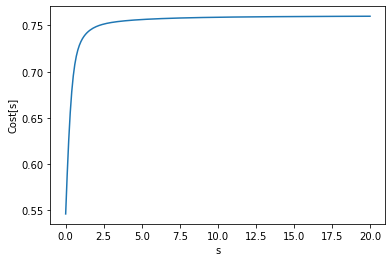

In [24]:
network131 = randomNetwork([1,3,1], 50)
plotlist131, unitaries131 = qnnTraining(network131[0], network131[1], network131[2], 1, 0.1, 200)

for i in range(len(plotlist131[1])):
    if plotlist131[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist131[0], plotlist131[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [25]:
exporttocsv('classif131.csv',plotlist131)

In [26]:
costFunc(network131[0], unitaries131, network131[2], 1000)

0.03041956059945513

In [27]:
howManyWrong(network131[0], unitaries131, network131[2], 1000)

0.0

### Training a 1-1 network

Trained 400 rounds for a [1, 1] network and 50 training pairs in 53.02 seconds
Exceeds cost of 0.75 at training step 25


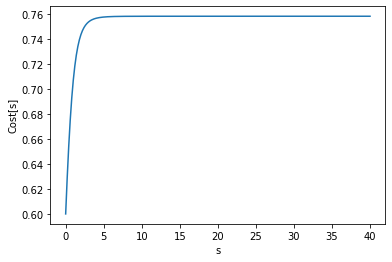

In [28]:
network11 = randomNetwork([1,1], 50)
plotlist11, unitaries11 = qnnTraining(network11[0], network11[1], network11[2], 1, 0.1, 400)

for i in range(len(plotlist11[1])):
    if plotlist11[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist11[0], plotlist11[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [29]:
exporttocsv('classif11.csv',plotlist11)

In [30]:
costFunc(network11[0], unitaries11, network11[2], 1000)

0.022901331528189312

In [31]:
howManyWrong(network11[0], unitaries11, network11[2], 1000)

0.0

### Training a 1-1-1 network

Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 118.26 seconds
Exceeds cost of 0.75 at training step 36


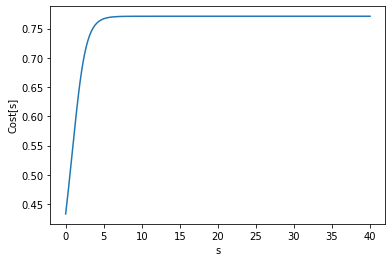

In [32]:
network111 = randomNetwork([1,1,1], 50)
plotlist111, unitaries111 = qnnTraining(network111[0], network111[1], network111[2], 1, 0.1, 400)

for i in range(len(plotlist111[1])):
    if plotlist111[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist111[0], plotlist111[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [33]:
exporttocsv('classif111.csv',plotlist111)

In [34]:
costFunc(network111[0], unitaries111, network111[2], 1000)

0.0966785429194373

In [35]:
howManyWrong(network111[0], unitaries111, network111[2], 1000)

0.1

### Training a 1-5-1 network

Trained 200 rounds for a [1, 5, 1] network and 50 training pairs in 301.36 seconds


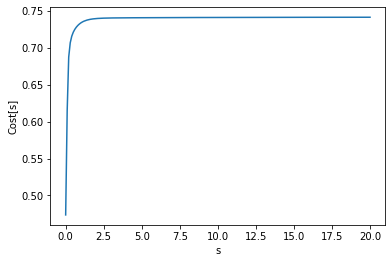

In [25]:
network151 = randomNetwork([1,5,1], 50)
plotlist151, unitaries151 = qnnTraining(network151[0], network151[1], network151[2], 1, 0.1, 200)

for i in range(len(plotlist151[1])):
    if plotlist151[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist151[0], plotlist151[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [26]:
exporttocsv('classif151.csv',plotlist151)

In [27]:
costFunc(network151[0], unitaries151, network151[2], 1000)

0.026817663005427726

In [28]:
howManyWrong(network151[0], unitaries151, network151[2], 1000)

0.0

### Training a 1-3-3-1 network

Trained 200 rounds for a [1, 3, 3, 1] network and 50 training pairs in 256.67 seconds
Exceeds cost of 0.75 at training step 18


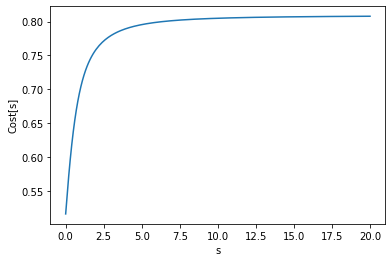

In [40]:
network1331 = randomNetwork([1,3,3,1], 50)
plotlist1331, unitaries1331 = qnnTraining(network1331[0], network1331[1], network1331[2], 1, 0.1, 200)

for i in range(len(plotlist1331[1])):
    if plotlist1331[1][i] >= 0.75:
        print("Exceeds cost of 0.75 at training step "+str(i))
        break

plt.plot(plotlist1331[0], plotlist1331[1])
plt.xlabel("s")
plt.ylabel("Cost[s]")
plt.show()

In [41]:
exporttocsv('classif1331.csv',plotlist1331)

In [42]:
costFunc(network1331[0], unitaries1331, network1331[2], 1000)

0.031306895686119954

In [43]:
howManyWrong(network1331[0], unitaries1331, network1331[2], 1000)

0.02

## 2.2 Ablility for classification

In the following, training and classification are done twelve times for each of the previously used five architectures. The list $\text{errordata}$ contains the fraction of wrong classifications for each training.

In [24]:
errordata = [[], [], [], [], []]
for i in range(12):
    network11 = randomNetwork([1,1], 50)
    plotlist11, unitaries11 = qnnTraining(network11[0], network11[1], network11[2], 1, 0.1, 400)
    error11 = howManyWrong(network11[0], unitaries11, network11[2], 1000)
    errordata[0].append(error11)
    network111 = randomNetwork([1,1,1], 50)
    plotlist111, unitaries111 = qnnTraining(network111[0], network111[1], network111[2], 1, 0.1, 400)
    error111 = howManyWrong(network111[0], unitaries111, network111[2], 1000)
    errordata[1].append(error111)
    network131 = randomNetwork([1,3,1], 50)
    plotlist131, unitaries131 = qnnTraining(network131[0], network131[1], network131[2], 1, 0.1, 200)
    error131 = howManyWrong(network131[0], unitaries131, network131[2], 1000)
    errordata[2].append(error131)
    network151 = randomNetwork([1,5,1], 50)
    plotlist151, unitaries151 = qnnTraining(network151[0], network151[1], network151[2], 1, 0.1, 100)
    error151 = howManyWrong(network151[0], unitaries151, network151[2], 1000)
    errordata[3].append(error151)
    network1331 = randomNetwork([1,3,3,1], 50)
    plotlist1331, unitaries1331 = qnnTraining(network1331[0], network1331[1], network1331[2], 1, 0.1, 200)
    error1331 = howManyWrong(network1331[0], unitaries1331, network1331[2], 1000)
    errordata[4].append(error1331)

print(errordata)

Trained 400 rounds for a [1, 1] network and 50 training pairs in 52.2 seconds
Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 107.96 seconds
Trained 200 rounds for a [1, 3, 1] network and 50 training pairs in 113.1 seconds
Trained 100 rounds for a [1, 5, 1] network and 50 training pairs in 150.24 seconds
Trained 200 rounds for a [1, 3, 3, 1] network and 50 training pairs in 279.28 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 50.18 seconds
Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 107.16 seconds
Trained 200 rounds for a [1, 3, 1] network and 50 training pairs in 138.37 seconds
Trained 100 rounds for a [1, 5, 1] network and 50 training pairs in 139.76 seconds
Trained 200 rounds for a [1, 3, 3, 1] network and 50 training pairs in 272.02 seconds
Trained 400 rounds for a [1, 1] network and 50 training pairs in 59.46 seconds
Trained 400 rounds for a [1, 1, 1] network and 50 training pairs in 105.78 seconds
Trained 200 

Create a csv file:

In [25]:
with open('errordata.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['1-1', '1-1-1', '1-3-1', '1-5-1', '1-3-3-1'])
    filewriter.writerows(list(map(list, zip(*errordata))))

Compute the mean $\frac{1}{N}\sum\epsilon_{i}$ and the standard deviation $\sqrt{\frac{1}{N-1}\sum(\epsilon_{i}-\bar{\epsilon})^2}$ for each architecture:

In [26]:
meanAndStd = [[], [], [], [], []]
for i in range(5):
    meanAndStd[i].append(np.mean(errordata[i]))
    meanAndStd[i].append(np.std(errordata[i], ddof=1))

In [27]:
print(meanAndStd)

[[0.041666666666666664, 0.03459724984691265], [0.04499999999999999, 0.03424510582152248], [0.04833333333333334, 0.030100840620497726], [0.03666666666666667, 0.0238683256575942], [0.045000000000000005, 0.030895719032666233]]


## 2.3 Generalization

### Subset training for a 1-1 network

n=5, i=0
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.63 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.55 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.8 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.37 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.38 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.37 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.46 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.88 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.69 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.66 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.68 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.76 seconds
Trained 200 rounds for a [1, 1] network and 5 training pairs in 2.92

Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.4 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.87 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.51 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.38 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.56 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.53 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.38 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.41 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.53 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.54 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.38 seconds
Trained 200 rounds for a [1, 1] network and 30 training pairs in 14.25 seconds
Trained 200 rounds for a [1, 1] network and 30 traini

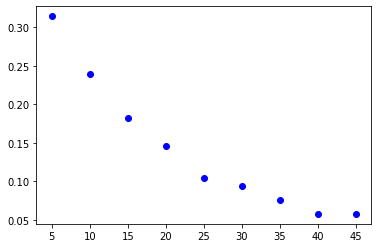

In [25]:
subsetNetwork11 = randomNetwork([1,1], 50)

start = time() #Optional

pointsX = [5,10,15,20,25,30,35,40,45]
pointsAverage = [subsetTrainingAvg(subsetNetwork11[0], subsetNetwork11[1], subsetNetwork11[2], 1.5, 0.1, 200, 20, n, 1000, alertIt=20) for n in pointsX]

print(time() - start) #Optional

pointsAverageCost = []
pointsAverageError = []
for k in range(len(pointsAverage)):
    pointsAverageCost.append(pointsAverage[k][0])
    pointsAverageError.append(pointsAverage[k][1])
plt.plot(pointsX, pointsAverageError, 'bo')
plt.show()

In [26]:
exporttocsv('averagecost.csv', [pointsX,pointsAverageCost])
exporttocsv('averageerror.csv', [pointsX,pointsAverageError])

### Subset training for a 1-3-1 network

n=5, i=0
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 8.08 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 8.27 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 7.98 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 9.46 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 8.59 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 8.41 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 8.53 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 9.97 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 8.65 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 8.43 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 9.79 seconds
Trained 150 rounds for a [1, 3, 1] network and 5 training pairs in 9.78 seconds
Trained 150 rounds for a [1, 3,

Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 46.89 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 47.54 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 47.31 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 47.29 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 47.67 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 49.83 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 47.05 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 46.67 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 45.98 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 46.91 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 48.52 seconds
Trained 150 rounds for a [1, 3, 1] network and 30 training pairs in 46.17 seconds
Trained 150 roun

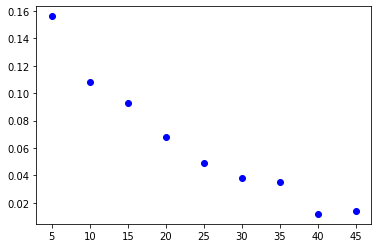

In [25]:
subsetNetwork131 = randomNetwork([1,3,1], 50)

start = time() #Optional

pointsX = [5,10,15,20,25,30,35,40,45]
pointsAverage131 = [subsetTrainingAvg(subsetNetwork131[0], subsetNetwork131[1], subsetNetwork131[2], 1.5, 0.1, 150, 20, n, 1000, alertIt=20) for n in pointsX]

print(time() - start) #Optional

pointsAverageCost131 = []
pointsAverageError131 = []
for k in range(len(pointsAverage131)):
    pointsAverageCost131.append(pointsAverage131[k][0])
    pointsAverageError131.append(pointsAverage131[k][1])
plt.plot(pointsX, pointsAverageError131, 'bo')
plt.show()

In [26]:
exporttocsv('averagecost131.csv', [pointsX,pointsAverageCost131])
exporttocsv('averageerror131.csv', [pointsX,pointsAverageError131])

## 2.4 Robustness to noisy data

In [44]:
noiseTrainingData = randomTrainingData(100)
noiseNoisyData = [[randomQubitState(1), choice([qubit0,qubit1])] for i in range(100)]
noiseWrongData = wrongLabelData(100)

### 1-1 network

#### parts of the data replaced by states with random labels:

Trained 300 rounds for a [1, 1] network and 100 training pairs in 79.84 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 76.33 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 70.74 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 67.53 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 68.26 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 68.71 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 67.72 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 68.13 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 67.96 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 80.54 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 98.74 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 69.94 seconds
Trained 300 rounds for a [1, 1] network 

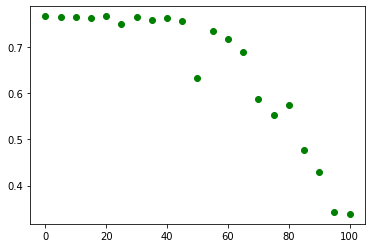

In [45]:
start = time() #Optional

noiseNetwork11 = randomNetwork([1,1], 0)
noisePlotList11, noiseNewList11 = noisyDataTraining(noiseNetwork11[0], noiseNetwork11[1], noiseTrainingData.copy(), noiseNoisyData.copy(), 1, 0.1, 300, 100, 5)

print(time() - start) #Optional

plt.plot(noisePlotList11[0], noisePlotList11[1], 'go')
plt.show() 

rate of wrong classifications:

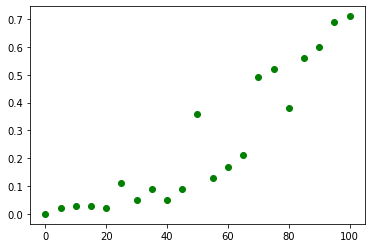

In [46]:
plt.plot(noiseNewList11[0], noiseNewList11[1], 'go')
plt.show() 

In [47]:
exporttocsv('noisecost11.csv',noisePlotList11)
exporttocsv('noiseerror11.csv',noiseNewList11)

#### parts of the data replaced by states with wrong labels:

Trained 300 rounds for a [1, 1] network and 100 training pairs in 69.39 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 70.54 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 70.83 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 70.58 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 68.94 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 69.27 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 73.63 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 70.68 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 68.87 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 70.2 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 69.83 seconds
Trained 300 rounds for a [1, 1] network and 100 training pairs in 72.27 seconds
Trained 300 rounds for a [1, 1] network a

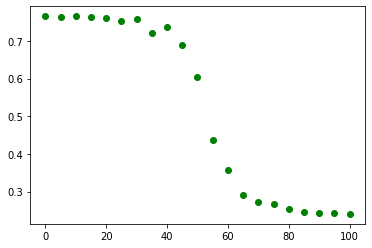

In [48]:
start = time() #Optional

wrongLabelNetwork11 = randomNetwork([1,1], 0)
wrongLabelPlotList11, wrongLabelNewList11 = noisyDataTraining(wrongLabelNetwork11[0], wrongLabelNetwork11[1], noiseTrainingData.copy(), noiseWrongData.copy(), 1, 0.1, 300, 100, 5)

print(time() - start) #Optional

plt.plot(wrongLabelPlotList11[0], wrongLabelPlotList11[1], 'go')
plt.show() 

rate of wrong classifications:

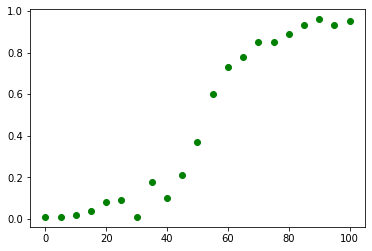

In [49]:
plt.plot(wrongLabelNewList11[0], wrongLabelNewList11[1], 'go')
plt.show() 

In [50]:
exporttocsv('wronglabelcost11.csv',wrongLabelPlotList11)
exporttocsv('wronglabelerror11.csv',wrongLabelNewList11)

### 1-3-1 network

#### parts of the data replaced by states with random labels:

Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 109.61 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 110.58 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 112.87 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 102.07 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 106.12 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 97.73 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 102.3 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 99.45 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 100.53 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 98.77 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 99.75 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 97.77 second

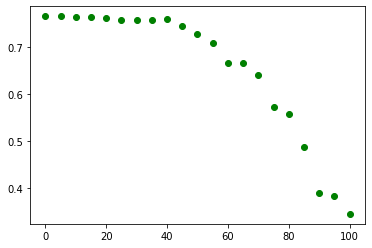

In [51]:
start = time() #Optional

noiseNetwork131 = randomNetwork([1,3,1], 0)
noisePlotList131, noiseNewList131 = noisyDataTraining(noiseNetwork131[0], noiseNetwork131[1], noiseTrainingData.copy(), noiseNoisyData.copy(), 1, 0.1, 100, 100, 5)

print(time() - start) #Optional

plt.plot(noisePlotList131[0], noisePlotList131[1], 'go')
plt.show()

rate of wrong classifications:

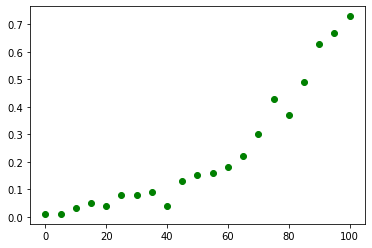

In [52]:
plt.plot(noiseNewList131[0], noiseNewList131[1], 'go')
plt.show()

In [53]:
exporttocsv('noisecost131.csv',noisePlotList131)
exporttocsv('noiseerror131.csv',noiseNewList131)

#### parts of the data replaced by states with wrong labels:

Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 98.55 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 98.83 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 102.17 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 101.0 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 99.4 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 99.42 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 99.67 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 99.37 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 99.47 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 98.76 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 100.93 seconds
Trained 100 rounds for a [1, 3, 1] network and 100 training pairs in 98.64 seconds
Tra

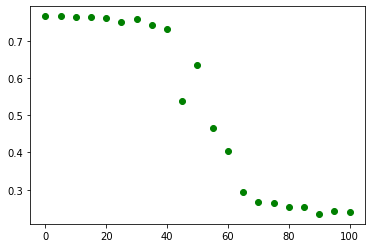

In [54]:
start = time() #Optional

wrongLabelNetwork131 = randomNetwork([1,3,1], 0)
wrongLabelPlotList131, wrongLabelNewList131 = noisyDataTraining(wrongLabelNetwork131[0], wrongLabelNetwork131[1], noiseTrainingData.copy(), noiseWrongData.copy(), 1, 0.1, 100, 100, 5)

print(time() - start) #Optional

plt.plot(wrongLabelPlotList131[0], wrongLabelPlotList131[1], 'go')
plt.show()

rate of wrong classifications:

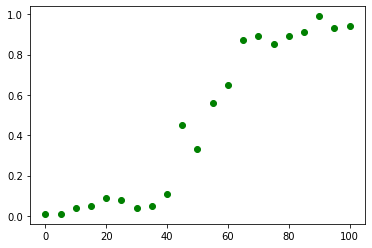

In [55]:
plt.plot(wrongLabelNewList131[0], wrongLabelNewList131[1], 'go')
plt.show()

In [56]:
exporttocsv('wronglabelcost131.csv',wrongLabelPlotList131)
exporttocsv('wronglabelerror131.csv',wrongLabelNewList131)